# Notebook Aim
To investigate .ttl files and parse them

In [5]:
# https://github.com/RDFLib/rdflib
#!pip install rdflib
from rdflib import Graph

## Ontology File
The RDf data dump comes with an ontology file that can use to know which RDF types to expect in the `.ttl` files.

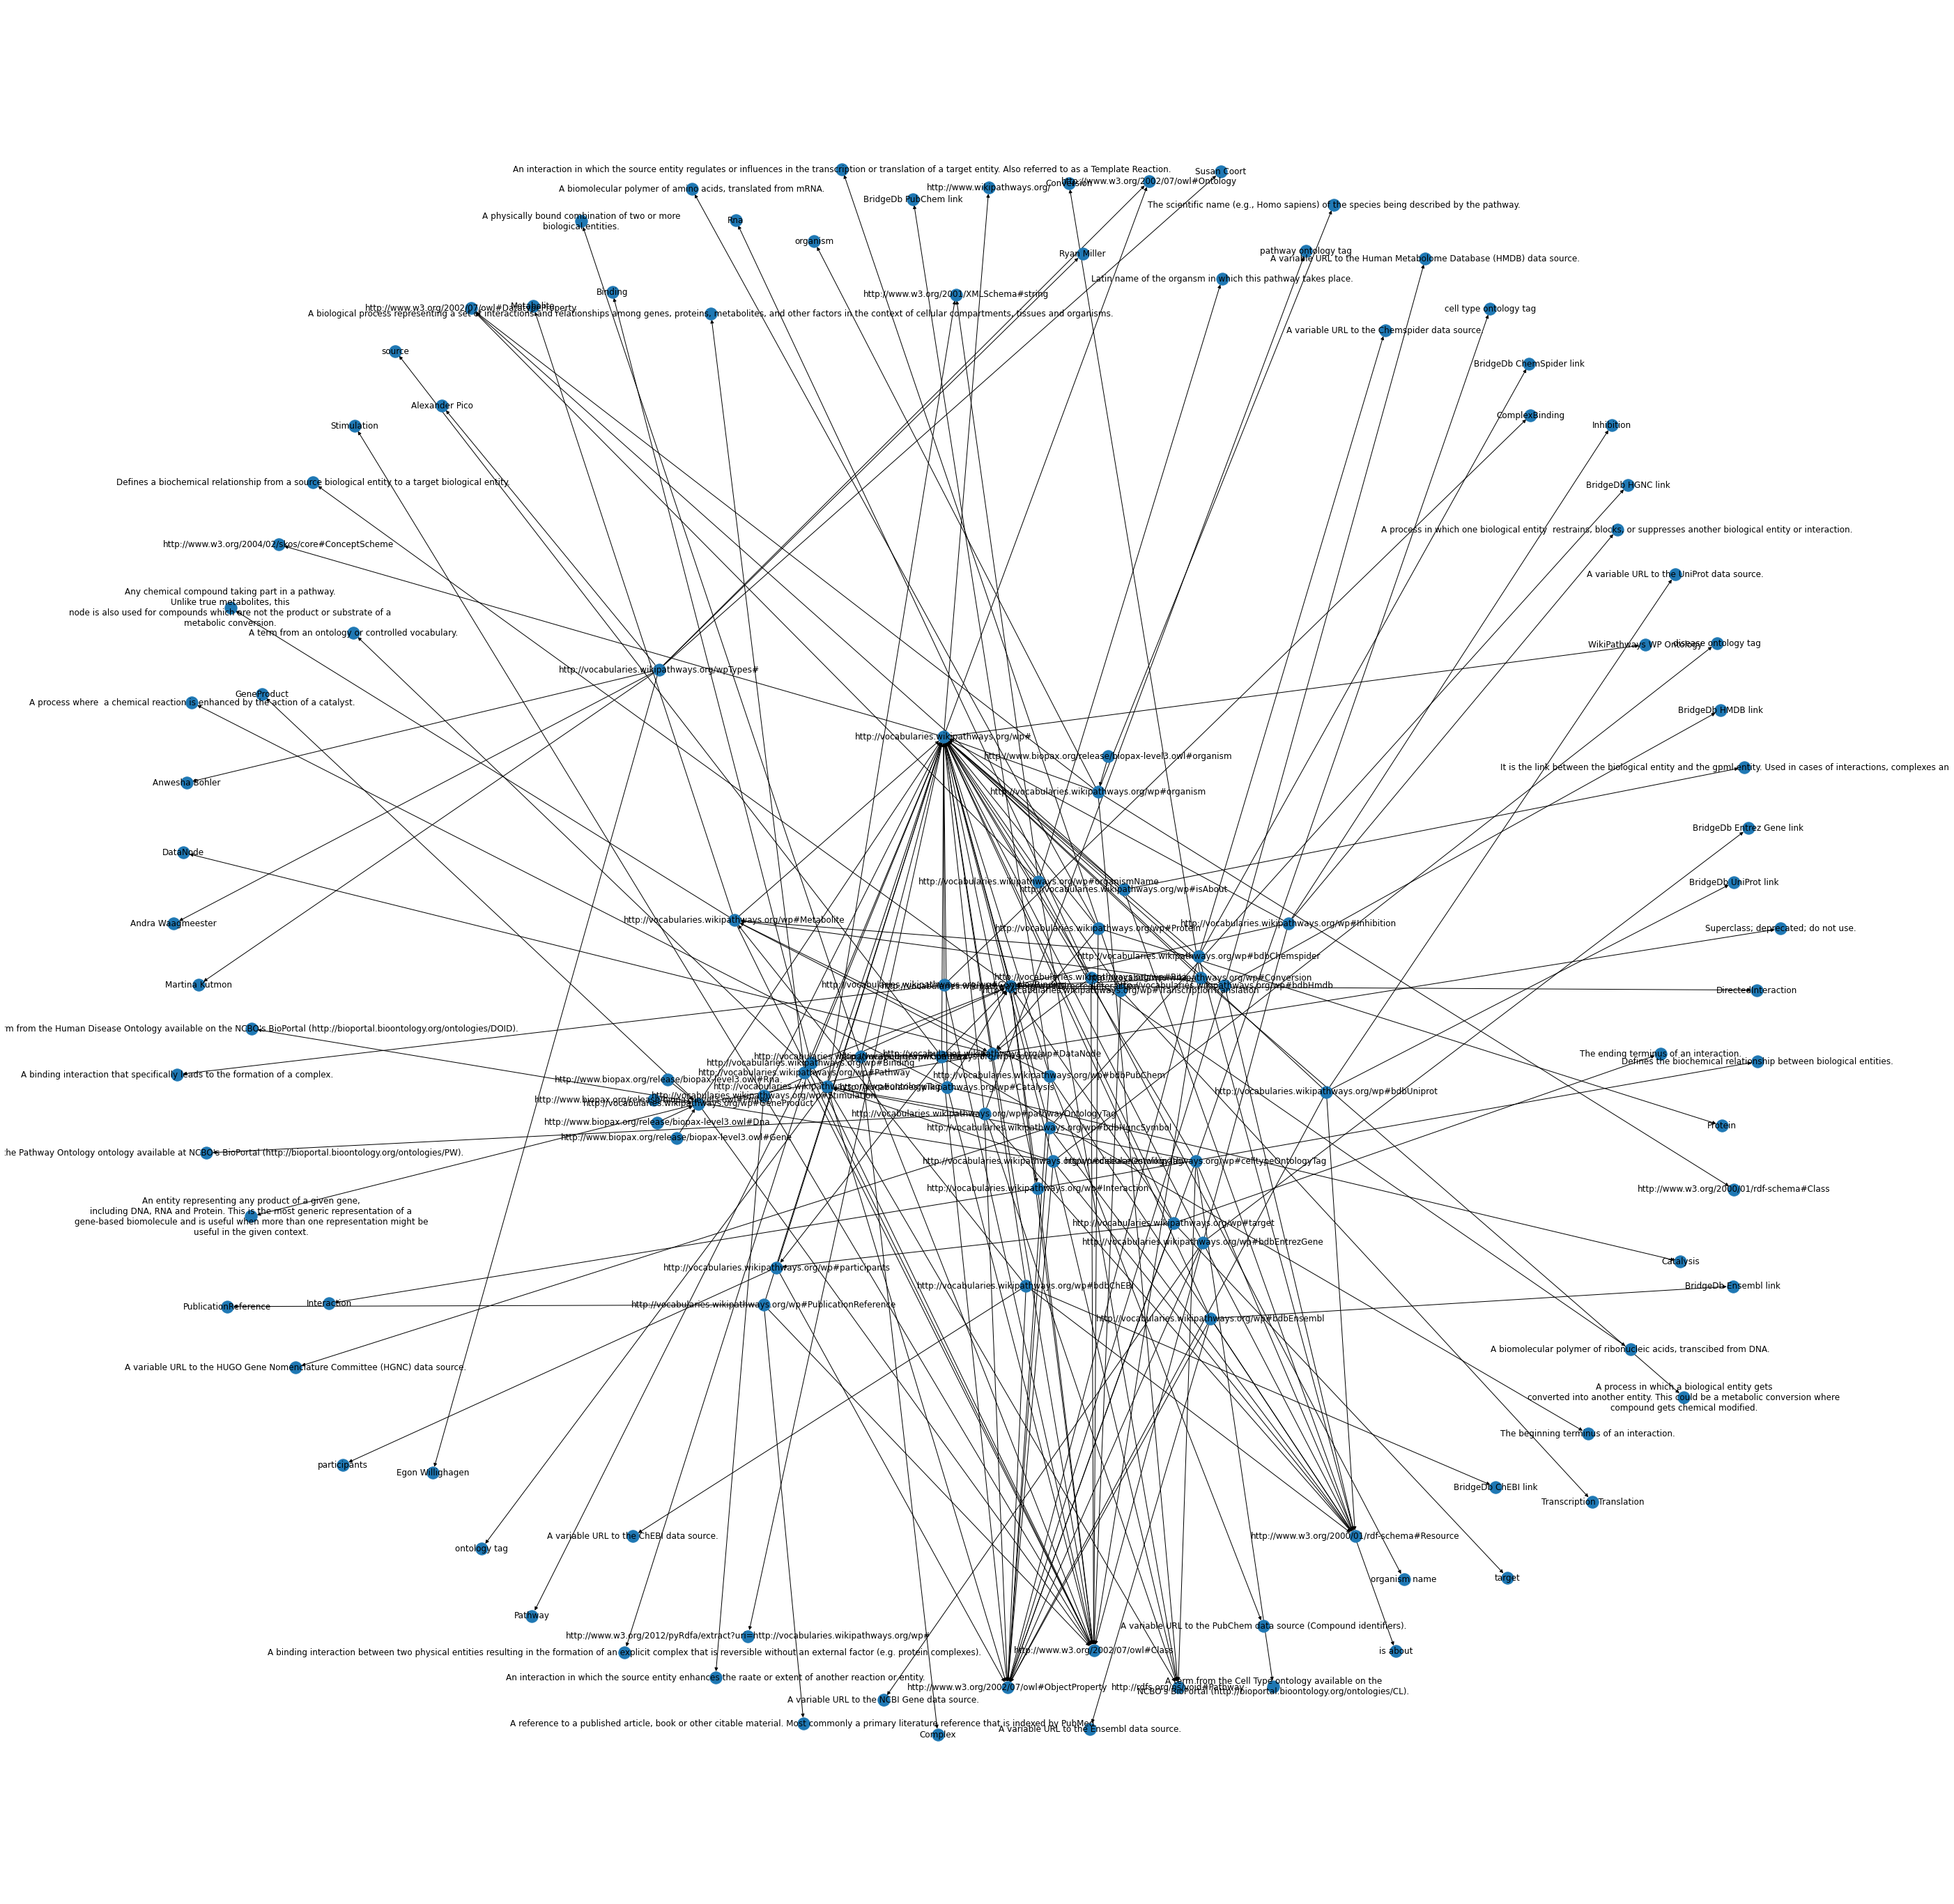

In [65]:
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
import networkx as nx
import matplotlib.pyplot as plt

url = 'https://www.w3.org/TeamSubmission/turtle/tests/test-30.ttl'

onto_graph = Graph()
result = onto_graph.parse("./wpOntology.ttl", format='turtle')

G = rdflib_to_networkx_multidigraph(result)

# Plot Networkx instance of RDF Graph
pos = nx.spring_layout(G, scale=2)
plt.figure(figsize=(50,50))
edge_labels = nx.get_edge_attributes(G, 'r')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
nx.draw(G, with_labels=True)

#if not in interactive mode for 

plt.savefig("ontology_graph.png")

In [7]:
g = Graph()

# Parse in an RDF file hosted on the Internet
wp111g = g.parse("./WP111.ttl")

In [8]:
len(wp111g)  # Number of subj/pred/obj

2353

In [12]:
for subj, pred, obj in wp111g:
    s = subj
    p = pred
    o = obj
    break

In [18]:
# Getting labels of GeneProducts
q = """
    PREFIX dc: <http://purl.org/dc/elements/1.1/>
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs:    <http://www.w3.org/2000/01/rdf-schema#>

    SELECT ?label
    WHERE {
        ?p rdf:type wp:GeneProduct .

        ?p rdfs:label ?label .
    }
"""
for r in wp111g.query(q):
    print(r["label"])
    break

NDUFS3


In [48]:
# Check interactions
# Getting labels of GeneProducts
q = """
    PREFIX dc: <http://purl.org/dc/elements/1.1/>
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX wp: <http://vocabularies.wikipathways.org/wp#>

    SELECT ?type ?source
    WHERE {
        ?p rdfs:label wp:Interaction .

        ?p rdf:type ?type .
        ?p wp:source ?source .
    }
"""
for r in wp111g.query(q):
    print(r["type"])
    print(r["source"])

http://vocabularies.wikipathways.org/wp#Catalysis
http://rdf.wikipathways.org/Pathway/WP111_r117097/Complex/fdc14
http://vocabularies.wikipathways.org/wp#DirectedInteraction
http://rdf.wikipathways.org/Pathway/WP111_r117097/Complex/fdc14
http://vocabularies.wikipathways.org/wp#Interaction
http://rdf.wikipathways.org/Pathway/WP111_r117097/Complex/fdc14
http://vocabularies.wikipathways.org/wp#DirectedInteraction
https://identifiers.org/chebi/CHEBI:15378
http://vocabularies.wikipathways.org/wp#Interaction
https://identifiers.org/chebi/CHEBI:15378
http://vocabularies.wikipathways.org/wp#Catalysis
http://rdf.wikipathways.org/Pathway/WP111_r117097/Complex/ad4b9
http://vocabularies.wikipathways.org/wp#DirectedInteraction
http://rdf.wikipathways.org/Pathway/WP111_r117097/Complex/ad4b9
http://vocabularies.wikipathways.org/wp#Interaction
http://rdf.wikipathways.org/Pathway/WP111_r117097/Complex/ad4b9
http://vocabularies.wikipathways.org/wp#DirectedInteraction
https://identifiers.org/kegg.compoun

In [45]:
print(test["type"])

http://vocabularies.wikipathways.org/wp#Catalysis
